# Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Прочитаем файл *music_project.csv* и сохраним его в переменной *df*. 

In [2]:
df = pd.read_csv('/datasets/music_project.csv')

Получение первых 10 строк таблицы.

In [3]:
df.head(10)

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Saint-Petersburg,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Moscow,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Saint-Petersburg,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Moscow,08:34:34,Monday
5,842029A1,Преданная,IMPERVTOR,rusrap,Saint-Petersburg,13:09:41,Friday
6,4CB90AA5,True,Roman Messer,dance,Moscow,13:00:07,Wednesday
7,F03E1C1F,Feeling This Way,Polina Griffith,dance,Moscow,20:47:49,Wednesday
8,8FA1D3BE,И вновь продолжается бой,NaN,ruspop,Moscow,09:17:40,Friday
9,E772D5C0,Pessimist,NaN,dance,Saint-Petersburg,21:20:49,Wednesday


Общая информация о данных таблицы *df*.




In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
  userID    65079 non-null object
Track       63848 non-null object
artist      57876 non-null object
genre       63881 non-null object
  City      65079 non-null object
time        65079 non-null object
Day         65079 non-null object
dtypes: object(7)
memory usage: 3.5+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 7 столбцов, тип данных у каждого столбца - object.

Подробно разберём, какие в *df* столбцы и какую информацию они содержат:

* userID — идентификатор пользователя;
* Track — название трека;  
* artist — имя исполнителя;
* genre — название жанра;
* City — город, в котором происходило прослушивание;
* time — время, в которое пользователь слушал трек;
* Day — день недели.

Количество значений в столбцах различается. Это говорит о том, что в данных есть null значения.



In [5]:
df.shape


(65079, 7)

**Выводы**

Каждая строка таблицы содержит информацию о композициях определённого жанра в определённом исполнении, которые пользователи слушали в одном из городов в определённое время и день недели. Две проблемы, которые нужно решать: пропуски и некачественные названия столбцов. Для проверки рабочих гипотез особенно ценны столбцы *time*, *day* и *City*. Данные из столбца *genre* позволят узнать самые популярные жанры.

# Этап 2. Предобработка данных

Исключим пропуски, переименуем столбцы, а также проверим данные на наличие дубликатов.

Получаем перечень названий столбцов. Какая наблюдается проблема — кроме тех, что уже были названы ранее?

In [6]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

В названиях столбцов есть пробелы, которые могут затруднять доступ к данным.

Переименуем столбцы для удобства дальнейшей работы. Проверим результат.



In [7]:
new_columns = ['user_id', 'track_name', 'artist_name', 'genre_name', 'city', 'time', 'weekday']
df.set_axis(new_columns, axis = 'columns', inplace = True)

In [8]:
df.columns

Index(['user_id', 'track_name', 'artist_name', 'genre_name', 'city', 'time',
       'weekday'],
      dtype='object')

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [9]:
df.isnull().sum()

user_id           0
track_name     1231
artist_name    7203
genre_name     1198
city              0
time              0
weekday           0
dtype: int64

Пустые значения свидетельствуют, что для некоторых треков доступна не вся информация. Причины могут быть разные: скажем,  не назван конкретный исполнитель народной песни. Хуже, если проблемы с записью данных. Каждый отдельный случай необходимо разобрать и выявить причину.

Заменяем пропущенные значения в столбцах с названием трека и исполнителя на строку 'unknown'. После этой операции нужно убедиться, что таблица больше не содержит пропусков.

In [10]:
df['track_name'] = df['track_name'].fillna('unknown')

In [11]:
df['artist_name'] = df['artist_name'].fillna('unknown')

In [12]:
df.isnull().sum()

user_id           0
track_name        0
artist_name       0
genre_name     1198
city              0
time              0
weekday           0
dtype: int64

Удаляем в столбце с жанрами пустые значения; убеждаемся, что их больше не осталось.

In [13]:
df.dropna(subset = ['genre_name'], inplace = True)

In [14]:
df['genre_name'].isnull().sum()

0

Необходимо установить наличие дубликатов.  Если найдутся, удаляем, и проверяем, все ли удалились.

In [15]:
df.duplicated().sum()

3755

In [16]:
df = df.drop_duplicates().reset_index(drop = True)

In [17]:
df.duplicated().sum()

0

Дубликаты могли появиться вследствие сбоя в записи данных. Стоит обратить внимание и разобраться с причинами появления такого «информационного мусора».

Сохраняем список уникальных значений столбца с жанрами в переменной *genres_list*. 

Объявим функцию *find_genre()* для поиска неявных дубликатов в столбце с жанрами. Например, когда название одного и того же жанра написано разными словами.





In [18]:
genres_list = df['genre_name'].unique()

In [19]:
# <создание функции find_genre()>
# функция принимает как параметр строку с названием искомого жанра
# в теле объявляется переменная-счётчик, ей присваивается значение 0,
# затем цикл for проходит по списку уникальных значений
# если очередной элемент списка равен параметру функции, 
# то значение счётчика увеличивается на 1
# по окончании работы цикла функция возвращает значение счётчика
def find_genre(genre):
    count = 0
    for g in genres_list:
        if g == genre:
            count += 1
    return count

Вызов функции *find_genre()* для поиска различных вариантов названия жанра хип-хоп в таблице.

Правильное название — *hiphop*. Поищем другие варианты:

* hip
* hop
* hip-hop


In [20]:
find_genre('hip')

1

In [21]:
find_genre('hop')

0

In [22]:
find_genre('hip-hop')

0

Объявим функцию *find_hip_hop()*, которая заменяет  неправильное название этого жанра в столбце *'genre_name'* на *'hiphop'* и проверяет успешность выполнения замены.

Так исправляем все варианты написания, которые выявила проверка.

In [23]:
# <создание функции find_hip_hop()>
# функция принимает как параметры таблицу df и неверное название
# к столбцу 'genre_name' применяется специальный метод, 
# который заменяет второй параметр на строку 'hiphop'
# результат работы равен подсчитанному методом count() числу значений столбца, 
# которые равны второму параметру
# функция возвращает результат
def find_hip_hop(df, wrong):
    df['genre_name'] = df['genre_name'].replace(wrong, 'hiphop')
    count = df[df['genre_name'] == wrong]['genre_name'].count()
    return count

In [24]:
find_hip_hop(df, 'hip')

0

Получаем общую информацию о данных. Убеждаемся, что чистка выполнена успешно.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60126 entries, 0 to 60125
Data columns (total 7 columns):
user_id        60126 non-null object
track_name     60126 non-null object
artist_name    60126 non-null object
genre_name     60126 non-null object
city           60126 non-null object
time           60126 non-null object
weekday        60126 non-null object
dtypes: object(7)
memory usage: 3.2+ MB


**Вывод**

На этапе предобработки в данных обнаружились не только пропуски и проблемы с названиями столбцов, но и всяческие виды дубликатов. Их удаление позволит провести анализ точнее. Поскольку сведения о жанрах важно сохранить для анализа, не просто удаляем все пропущенные значения, но заполним пропущенные имена исполнителей и названия треков. Имена столбцов теперь корректны и удобны для дальнейшей работы.

# Действительно ли музыку в разных городах слушают по-разному?

Была выдвинута гипотеза, что в Москве и Санкт-Петербурге пользователи слушают музыку по-разному. Проверяем это предположение по данным о трёх днях недели — понедельнике, среде и пятнице.

Для каждого города устанавливаем количество прослушанных  в эти дни композиций с известным жанром, и сравниваем результаты.

Группируем данные по городу и вызовом метода *count()* подсчитываем композиции, для которых известен жанр.

In [26]:
# <группировка данных таблицы df по столбцу 'city' и подсчёт количества значений столбца 'genre_name'>
df_groupedby_genre_name = df.groupby('city')['genre_name'].count()
df_groupedby_genre_name

city
Moscow              41892
Saint-Petersburg    18234
Name: genre_name, dtype: int64

В Москве прослушиваний больше, чем в Питере, но это не значит, что Москва более активна. У Яндекс.Музыки в целом больше пользователей в Москве, поэтому величины сопоставимы.

Сгруппируем данные по дню недели и подсчитаем прослушанные в понедельник, среду и пятницу композиции, для которых известен жанр.

In [27]:
# <группировка данных по столбцу 'weekday' и подсчёт количества значений столбца 'genre_name'>
df_groupedby_weekday = df.groupby('weekday')['genre_name'].count()
df_groupedby_weekday

weekday
Friday       21482
Monday       20866
Wednesday    17778
Name: genre_name, dtype: int64

Text(0, 0.5, 'Weekday')

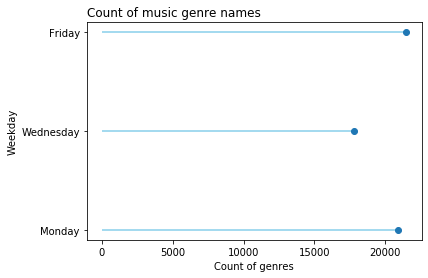

In [28]:
analyzed_days = ['Monday', 'Wednesday', 'Friday'] 
weekdays_genres_count = [20866, 17778, 21482]
plt.hlines(y = analyzed_days, xmin = 0, xmax = weekdays_genres_count, color = 'skyblue')
plt.plot(weekdays_genres_count, analyzed_days, "o")

plt.title("Count of music genre names", loc='left')
plt.xlabel('Count of genres')
plt.ylabel('Weekday')

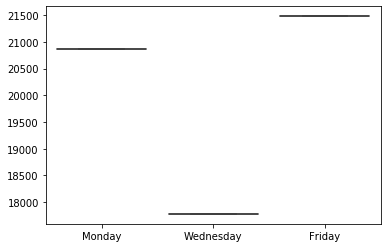

In [29]:
sns.boxplot(x = analyzed_days, y = weekdays_genres_count, palette = 'Blues')

Понедельник и пятница — время для музыки; по средам пользователи немного больше вовлечены в работу.

Создаём функцию *number_tracks()*, которая принимает как параметры таблицу, день недели и название города, а возвращает количество прослушанных композиций, для которых известен жанр. Проверяем количество прослушанных композиций для каждого города и понедельника, затем среды и пятницы.

In [30]:
# <создание функции number_tracks()>
# объявляется функция с тремя параметрами: df, day, city
# в переменной track_list сохраняются те строки таблицы df, для которых 
# значение в столбце 'weekday' равно параметру day
# и одновременно значение в столбце 'city' равно параметру city
# в переменной track_list_count сохраняется число значений столбца 'genre_name',
# рассчитанное методом count() для таблицы track_list
# функция возвращает значение track_list_count
def number_tracks(df, day, city):
    track_list = df[(df['weekday'] == day) & (df['city'] == city)]
    track_list_count = track_list['genre_name'].count()
    return track_list_count

In [31]:
# <список композиций для Москвы в понедельник>
msc_mon = number_tracks(df, 'Monday', 'Moscow')

In [32]:
# <список композиций для Санкт-Петербурга в понедельник>
spb_mon = number_tracks(df, 'Monday', 'Saint-Petersburg')

In [33]:
# <список композиций для Москвы в среду>
msc_wed = number_tracks(df, 'Wednesday', 'Moscow')

In [34]:
# <список композиций для Санкт-Петербурга в среду>
spb_wed = number_tracks(df, 'Wednesday', 'Saint-Petersburg')

In [35]:
# <список композиций для Москвы в пятницу>
msc_fri = number_tracks(df, 'Friday', 'Moscow')

In [36]:
# <список композиций для Санкт-Петербурга в пятницу>
spb_fri = number_tracks(df, 'Friday', 'Saint-Petersburg')


Сведём полученную информацию в одну таблицу, где ['city', 'monday', 'wednesday', 'friday'] названия столбцов.


In [37]:
# <таблица с полученными данными>
columns = ['city', 'monday', 'wednesday', 'friday']
data = [['Moscow', msc_mon, msc_wed, msc_fri],['Saint-Petersburg', spb_mon, spb_wed, spb_fri]]
table = pd.DataFrame(data = data, columns = columns)
table

,city,monday,wednesday,friday
0,Moscow,15347,10865,15680
1,Saint-Petersburg,5519,6913,5802


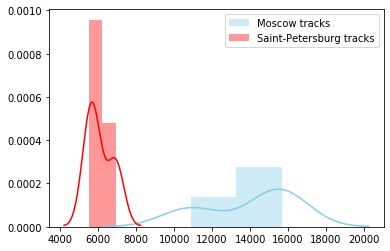

In [38]:
msc_tracks_by_days = [msc_mon, msc_wed, msc_fri]
spb_tracks_by_days = [spb_mon, spb_wed, spb_fri]
sns.distplot(msc_tracks_by_days, color = 'skyblue', label = 'Moscow tracks')
sns.distplot(spb_tracks_by_days, color = 'red', label = 'Saint-Petersburg tracks')
plt.legend()

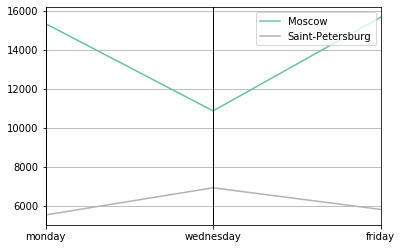

In [39]:
from pandas.plotting import parallel_coordinates
parallel_coordinates(table, 'city', colormap = plt.get_cmap("Set2"))
plt.show()

**Вывод**

Результаты показывают, что относительно среды музыку в Петербурге и Москве слушают «зеркально»: в Москве пики приходятся на понедельник и пятницу, а в среду время прослушивания снижается. Тогда как в Санкт-Петербурге среда — день самого большого интереса к музыке, а в понедельник и пятницу он меньше, причём почти одинаково меньше.

# Утро понедельника и вечер пятницы — разная музыка или одна и та же?

Ищем ответ на вопрос, какие жанры преобладают в разных городах в понедельник утром и в пятницу вечером. Есть предположение, что в понедельник утром пользователи слушают больше бодрящей музыки (например, жанра поп), а вечером пятницы — больше танцевальных (например, электронику).

Получим таблицы данных по Москве *moscow_general* и по Санкт-Петербургу *spb_general*.

In [40]:
# получение таблицы moscow_general из тех строк таблицы df, 
# для которых значение в столбце 'city' равно 'Moscow'
moscow_general = df[df['city'] == 'Moscow']
moscow_general

,user_id,track_name,artist_name,genre_name,city,time,weekday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Moscow,14:07:09,Friday
4,E2DC1FAE,Soul People,Space Echo,dance,Moscow,08:34:34,Monday
6,4CB90AA5,True,Roman Messer,dance,Moscow,13:00:07,Wednesday
7,F03E1C1F,Feeling This Way,Polina Griffith,dance,Moscow,20:47:49,Wednesday
8,8FA1D3BE,И вновь продолжается бой,unknown,ruspop,Moscow,09:17:40,Friday
...,...,...,...,...,...,...,...
60120,83A474E7,I Worship Only What You Bleed,The Black Dahlia Murder,extrememetal,Moscow,21:07:12,Monday
60121,729CBB09,My Name,McLean,rnb,Moscow,13:32:28,Wednesday
60123,C5E3A0D5,Jalopiina,unknown,industrial,Moscow,20:09:26,Friday
60124,321D0506,Freight Train,Chas McDevitt,rock,Moscow,21:43:59,Friday


In [41]:
# <получение таблицы spb_general>
spb_general = df[df['city'] == 'Saint-Petersburg']
spb_general

,user_id,track_name,artist_name,genre_name,city,time,weekday
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Saint-Petersburg,20:28:33,Wednesday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Saint-Petersburg,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Saint-Petersburg,08:37:09,Monday
5,842029A1,Преданная,IMPERVTOR,rusrap,Saint-Petersburg,13:09:41,Friday
9,E772D5C0,Pessimist,unknown,dance,Saint-Petersburg,21:20:49,Wednesday
...,...,...,...,...,...,...,...
60112,D94F810B,Theme from the Walking Dead,Proyecto Halloween,film,Saint-Petersburg,21:14:40,Monday
60113,BC8EC5CF,Red Lips: Gta (Rover Rework),Rover,electronic,Saint-Petersburg,21:06:50,Monday
60114,29E04611,Bre Petrunko,Perunika Trio,world,Saint-Petersburg,13:56:00,Monday
60115,1B91C621,(Hello) Cloud Mountain,sleepmakeswaves,postrock,Saint-Petersburg,09:22:13,Monday


Создаём функцию *genre_weekday()*, которая возвращает список жанров по запрошенному дню недели и времени суток с такого-то часа по такой-то.

In [42]:
# объявление функции genre_weekday() с параметрами df, day, time1, time2
# в переменной genre_list сохраняются те строки df, для которых одновременно:
# 1) значение в столбце 'weekday' равно параметру day,
# 2) значение в столбце 'time' больше time1 и
# 3) меньше time2.
# в переменной genre_list_sorted сохраняются в порядке убывания  
# первые 10 значений Series, полученной подсчётом числа значений 'genre_name'
# сгруппированной по столбцу 'genre_name' таблицы genre_list
# функция возвращает значение genre_list_sorted
def genre_weekday(df, day, time1, time2):
    genre_list = df[(df['weekday'] == day) & (time1 < df['time']) & (df['time'] < time2)]
    genre_list_sorted = genre_list.groupby('genre_name').count().sort_values(by = 'user_id', ascending = False).head(10)['city']
    return genre_list_sorted

Cравниваем полученные результаты по таблице для Москвы и Санкт-Петербурга в понедельник утром (с 7 до 11) и в пятницу вечером (с 17 до 23).

In [43]:
# <вызов функции для утра понедельника в Москве (вместо df таблица moscow_general)>
genre_weekday_msc_mon = genre_weekday(moscow_general, 'Monday', '07:00:00', '11:00:00')
genre_weekday_msc_mon

genre_name
pop            781
dance          549
electronic     480
rock           474
hiphop         286
ruspop         186
world          181
rusrap         175
alternative    164
classical      157
Name: city, dtype: int64

Text(0, 0.5, 'Genres')

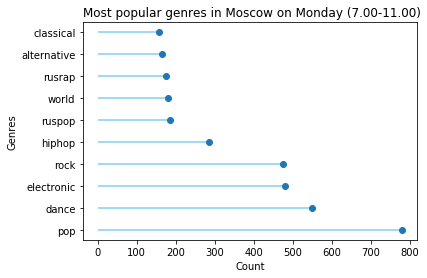

In [44]:
grouped_genres = ['pop', 'dance', 'electronic', 'rock', 'hiphop', 'ruspop', 'world', 'rusrap', 'alternative', 'classical'] 
plt.hlines(y = grouped_genres, xmin = 0, xmax = genre_weekday_msc_mon, color = 'skyblue')
plt.plot(genre_weekday_msc_mon, grouped_genres, "o")

plt.title("Most popular genres in Moscow on Monday (7.00-11.00)", loc='left')
plt.xlabel('Count')
plt.ylabel('Genres')

In [45]:
# <вызов функции для утра понедельника в Петербурге (вместо df таблица spb_general)>
genre_weekday_spb_mon = genre_weekday(spb_general, 'Monday', '07:00:00', '11:00:00')
genre_weekday_spb_mon

genre_name
pop            218
dance          182
rock           162
electronic     147
hiphop          80
ruspop          64
alternative     58
rusrap          55
jazz            44
classical       40
Name: city, dtype: int64

In [46]:
# <вызов функции для вечера пятницы в Москве>
genre_weekday_msc_fri = genre_weekday(moscow_general, 'Friday', '17:00:00', '23:00:00')
genre_weekday_msc_fri

genre_name
pop            713
rock           517
dance          495
electronic     482
hiphop         273
world          208
ruspop         170
alternative    163
classical      163
rusrap         142
Name: city, dtype: int64

In [47]:
# <вызов функции для вечера пятницы в Питере>
genre_weekday_spb_fri = genre_weekday(spb_general, 'Friday', '17:00:00', '23:00:00')
genre_weekday_spb_fri

genre_name
pop            256
rock           216
electronic     216
dance          210
hiphop          97
alternative     63
jazz            61
classical       60
rusrap          59
world           54
Name: city, dtype: int64

<BarContainer object of 5 artists>

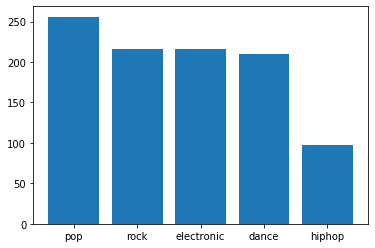

In [48]:
grouped_genres_spb_fri = ['pop', 'rock', 'electronic', 'dance', 'hiphop']
#, 'alternative', 'jazz', 'classical', 'rusrap', 'world']
plt.bar(grouped_genres_spb_fri, genre_weekday_spb_fri[:5])

Популярные жанры в понедельник утром в Питере и Москве оказались похожи: везде, как и предполагалось, популярен поп. Несмотря на это, концовка топ-10 для двух городов различается: в Питере в топ-10 входит джаз и русский рэп, а в Москве жанр *world*.

В конце недели ситуация не меняется. Поп-музыка всё так же на первом месте. Опять разница заметна только в концовке топ-10, где в Питере пятничным вечером тоже присутствует жанр *world*.

**Вывод**

Жанр поп безусловный лидер, а топ-5 в целом не различается в обеих столицах. При этом видно, что концовка списка более «живая»: для каждого города выделяются более характерные жанры, которые действительно меняют свои позиции в зависимости от дня недели и времени.

# Москва и Питер — две разные столицы, два разных направления в музыке. Правда?

Гипотеза: Питер богат своей рэп-культурой, поэтому это направление там слушают чаще, а Москва — город контрастов, но основная масса пользователей слушает попсу.



Сгруппируем таблицу *moscow_general* по жанру, сосчитаем численность композиций каждого жанра методом *count()*, отсортируем в порядке убывания и сохраним результат в таблице *moscow_genres*.

Просмотрим первые 10 строк этой новой таблицы.

In [49]:
# одной строкой: группировка таблицы moscow_general по столбцу 'genre_name', 
# подсчёт числа значений 'genre_name' в этой группировке методом count(), 
# сортировка Series в порядке убывания и сохранение в moscow_genres
moscow_genres = moscow_general.groupby('genre_name')['genre_name'].count().sort_values(ascending = False)

In [50]:
# <просмотр первых 10 строк moscow_genres>
moscow_genres.head(10)

genre_name
pop            5892
dance          4435
rock           3965
electronic     3786
hiphop         2096
classical      1616
world          1432
alternative    1379
ruspop         1372
rusrap         1161
Name: genre_name, dtype: int64

Сгруппируем таблицу *spb_general* по жанру, сосчитаем численность композиций каждого жанра методом *count()*, отсортируем в порядке убывания и сохраним результат в таблице *spb_genres*.

Просматриваем первые 10 строк этой таблицы. Теперь можно сравнивать два города.

In [51]:
# <группировка таблицы spb_general, расчёт, сохранение в spb_genres>
spb_genres = spb_general.groupby('genre_name')['genre_name'].count().sort_values(ascending = False)

In [52]:
# <просмотр первых 10 строк spb_genres>
spb_genres.head(10)

genre_name
pop            2431
dance          1932
rock           1879
electronic     1736
hiphop          960
alternative     649
classical       646
rusrap          564
ruspop          538
world           515
Name: genre_name, dtype: int64

**Вывод**

В Москве, кроме абсолютно популярного жанра поп, есть направление русской популярной музыки. Значит, что интерес к этому жанру шире. А рэп, вопреки предположению, занимает в обоих городах близкие позиции.

# Этап 4. Результаты исследования


Рабочие гипотезы:

* музыку в двух городах — Москве и Санкт-Петербурге — слушают в разном режиме;

* списки десяти самых популярных жанров утром в понедельник и вечером в пятницу имеют характерные отличия;

* население двух городов предпочитает разные музыкальные жанры.

**Общие результаты**

Москва и Петербург сходятся во вкусах: везде преобладает популярная музыка. При этом зависимости предпочтений от дня недели в каждом отдельном городе нет — люди постоянно слушают то, что им нравится. Но между городами в разрезе дней неделей наблюдается зеркальность относительно среды: Москва больше слушает в понедельник и пятницу, а Петербург наоборот - больше в среду, но меньше в понедельник и пятницу.

В результате первая гипотеза не подтверждена (рэп слушают меньше, чем поп), вторая гипотеза подтверждена/не подтверждена > и третья < укажите подтверждена/не подтверждена >.